trials
    - sum of past data
    - average of past data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
import random
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
order_df = pd.read_csv('data/order_v2.csv')

C:\Users\IsmailKaraman\workspace\GitHub\dhl_datathon_21\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
order_df.shape

(28656570, 32)

In [4]:
order_df.head()

,order_week,material_num,customer_num,order_amount,order_sum2,order_sum3,order_sum4,order_sum5,order_sum7,order_sum10,...,prod_sum7,prod_sum10,prod_sum14,whole_sum2,whole_sum3,whole_sum4,whole_sum5,whole_sum7,whole_sum10,whole_sum14
0,1,91704,M10125,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,91704,M10140,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,91704,M10142,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,91704,M10143,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,91704,M10158,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
order_df.dtypes

order_week       int64
material_num    object
customer_num    object
order_amount     int64
order_sum2       int64
order_sum3       int64
order_sum4       int64
order_sum5       int64
order_sum7       int64
order_sum10      int64
order_sum14      int64
cust_sum2        int64
cust_sum3        int64
cust_sum4        int64
cust_sum5        int64
cust_sum7        int64
cust_sum10       int64
cust_sum14       int64
prod_sum2        int64
prod_sum3        int64
prod_sum4        int64
prod_sum5        int64
prod_sum7        int64
prod_sum10       int64
prod_sum14       int64
whole_sum2       int64
whole_sum3       int64
whole_sum4       int64
whole_sum5       int64
whole_sum7       int64
whole_sum10      int64
whole_sum14      int64
dtype: object

### additional datasets

### 2020

In [6]:
dates20 = pd.DataFrame(pd.date_range(start='01-01-2020', end='31-12-2020'), columns=['date'])

In [7]:
currency_20 = pd.read_csv('data/currency_20.csv', parse_dates=['date'])
currency_20.dropna(inplace=True)
currency_20['order_week'] = currency_20['date'].dt.week

for curr in ['EUR', 'USD']:
    for operator in ['min', 'max', 'avg', 'std']:
        currency_20[curr + '_' + operator] = currency_20[curr]
        
currency_20 = currency_20.groupby('order_week').agg({'EUR_min':'min', 'EUR_max':'max', 'EUR_avg':'mean', 'EUR_std':'std', 
                                               'USD_min':'min', 'USD_max':'max', 'USD_avg':'mean', 'USD_std':'std'}).reset_index()    

currency_20['USD_diff_1'] = currency_20['USD_avg'].diff(1)
currency_20['USD_diff_2'] = currency_20['USD_avg'].diff(2)
currency_20['USD_diff_3'] = currency_20['USD_avg'].diff(3)
currency_20['USD_diff_5'] = currency_20['USD_avg'].diff(5)
currency_20['USD_diff_7'] = currency_20['USD_avg'].diff(7)
currency_20['USD_diff_14'] = currency_20['USD_avg'].diff(14)

currency_20['EUR_diff_1'] = currency_20['EUR_avg'].diff(1)
currency_20['EUR_diff_2'] = currency_20['EUR_avg'].diff(2)
currency_20['EUR_diff_3'] = currency_20['EUR_avg'].diff(3)
currency_20['EUR_diff_5'] = currency_20['EUR_avg'].diff(5)
currency_20['EUR_diff_7'] = currency_20['EUR_avg'].diff(7)
currency_20['EUR_diff_14'] = currency_20['EUR_avg'].diff(14)
currency_20.fillna(method='bfill', inplace=True)

C:\Users\ISMAIL~1\AppData\Local\Temp/ipykernel_29564/3925827490.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  currency_20['order_week'] = currency_20['date'].dt.week


In [8]:
holidays_20 = pd.read_excel('data/holidays_20.xlsx', parse_dates=['date'])
holidays_20 = pd.merge(dates20, holidays_20, on=['date'], how='left')
holidays_20.fillna(1.0, inplace=True)
holidays_20['order_week'] = holidays_20['date'].dt.week
holidays_20 = holidays_20.groupby('order_week')['workday'].sum().reset_index()

C:\Users\ISMAIL~1\AppData\Local\Temp/ipykernel_29564/1395646822.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  holidays_20['order_week'] = holidays_20['date'].dt.week


In [9]:
tufe_20 = pd.read_excel('data/tufe_20.xlsx', parse_dates=['date'])
tufe_20.sort_values(by='date', inplace=True)
tufe_20['yearly_diff'] = tufe_20['yearly'].diff()
tufe_20['monthly_diff'] = tufe_20['monthly'].diff()
tufe_20.loc[11, 'yearly_diff'] = 12.15-11.84
tufe_20.loc[11, 'monthly_diff'] = 1.35-0.74
tufe_20 = pd.merge(dates20, tufe_20, on=['date'], how='left')
tufe_20.fillna(method='ffill', inplace=True)
tufe_20.columns = ['tufe_'+i for i in tufe_20.columns]
tufe_20['order_week'] = tufe_20['tufe_date'].dt.week
tufe_20 = tufe_20.groupby('order_week').min().reset_index().drop(['tufe_date'], axis=1)

C:\Users\ISMAIL~1\AppData\Local\Temp/ipykernel_29564/3738567944.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  tufe_20['order_week'] = tufe_20['tufe_date'].dt.week


In [10]:
ufe_20 = pd.read_excel('data/ufe_20.xlsx', parse_dates=['date'])
ufe_20.sort_values(by='date', inplace=True)
ufe_20['yearly_diff'] = ufe_20['yearly'].diff()
ufe_20['monthly_diff'] = ufe_20['monthly'].diff()
ufe_20.loc[11, 'yearly_diff'] = 8.84-7.36
ufe_20.loc[11, 'monthly_diff'] = 1.84-0.69
ufe_20 = pd.merge(dates20, ufe_20, on=['date'], how='left')
ufe_20.fillna(method='ffill', inplace=True)
ufe_20.columns = ['ufe_'+i for i in ufe_20.columns]
ufe_20['order_week'] = ufe_20['ufe_date'].dt.week
ufe_20 = ufe_20.groupby('order_week').min().reset_index().drop(['ufe_date'], axis=1)

C:\Users\ISMAIL~1\AppData\Local\Temp/ipykernel_29564/2252790197.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  ufe_20['order_week'] = ufe_20['ufe_date'].dt.week


In [11]:
order_df = pd.merge(order_df, currency_20, on=['order_week'], how='left')
order_df = pd.merge(order_df, tufe_20, on=['order_week'], how='left')
order_df = pd.merge(order_df, ufe_20, on=['order_week'], how='left')
order_df = pd.merge(order_df, holidays_20, on=['order_week'], how='left')

In [12]:
order_df.columns

Index(['order_week', 'material_num', 'customer_num', 'order_amount',
       'order_sum2', 'order_sum3', 'order_sum4', 'order_sum5', 'order_sum7',
       'order_sum10', 'order_sum14', 'cust_sum2', 'cust_sum3', 'cust_sum4',
       'cust_sum5', 'cust_sum7', 'cust_sum10', 'cust_sum14', 'prod_sum2',
       'prod_sum3', 'prod_sum4', 'prod_sum5', 'prod_sum7', 'prod_sum10',
       'prod_sum14', 'whole_sum2', 'whole_sum3', 'whole_sum4', 'whole_sum5',
       'whole_sum7', 'whole_sum10', 'whole_sum14', 'EUR_min', 'EUR_max',
       'EUR_avg', 'EUR_std', 'USD_min', 'USD_max', 'USD_avg', 'USD_std',
       'USD_diff_1', 'USD_diff_2', 'USD_diff_3', 'USD_diff_5', 'USD_diff_7',
       'USD_diff_14', 'EUR_diff_1', 'EUR_diff_2', 'EUR_diff_3', 'EUR_diff_5',
       'EUR_diff_7', 'EUR_diff_14', 'tufe_yearly', 'tufe_monthly',
       'tufe_yearly_diff', 'tufe_monthly_diff', 'ufe_yearly', 'ufe_monthly',
       'ufe_yearly_diff', 'ufe_monthly_diff', 'workday'],
      dtype='object')

In [13]:
drops = ['order_date', 'order_item', 'order_type', 'operation_type', 'palette_std','order_num']
categorical = ['material_num', 'customer_num', 'order_week']
numerical = [  'order_sum2', 'order_sum3', 'order_sum4', 'order_sum5', 'order_sum7',
               'order_sum10', 'order_sum14', 
                'EUR_min', 'EUR_max', 'EUR_avg', 'EUR_std', 'USD_min', 'USD_max', 'USD_avg', 'USD_std',
               'USD_diff_1', 'USD_diff_2', 'USD_diff_3', 'USD_diff_5', 'USD_diff_7',
               'USD_diff_14', 'EUR_diff_1', 'EUR_diff_2', 'EUR_diff_3', 'EUR_diff_5',
               'EUR_diff_7', 'EUR_diff_14', 'tufe_yearly', 'tufe_monthly',
               'tufe_yearly_diff', 'tufe_monthly_diff', 'ufe_yearly', 'ufe_monthly',
               'ufe_yearly_diff', 'ufe_monthly_diff', 'workday']
label = ['order_amount']

'cust_sum2', 'cust_sum3', 'cust_sum4',
'cust_sum5', 'cust_sum7', 'cust_sum10', 'cust_sum14', 'prod_sum2',
'prod_sum3', 'prod_sum4', 'prod_sum5', 'prod_sum7', 'prod_sum10',
'prod_sum14', 'whole_sum2', 'whole_sum3', 'whole_sum4', 'whole_sum5',
'whole_sum7', 'whole_sum10', 'whole_sum14',

In [14]:
all_contains_num = [re.findall(r'\d+', col_name) for col_name in [num for num in numerical if not ('USD' in num or 'EUR' in num)]]
divisions = {col:int(i[0]) for i, col in zip(all_contains_num, numerical) if len(i)>0}

In [15]:
for key, value in divisions.items():
    
    order_df[key] = order_df[key]/value

In [16]:
all_defined_columns = drops + categorical + numerical + label
if sorted(order_df.columns) != (sorted(all_defined_columns)):
    assert('Columns are not equal!')

### model 1 - only past data

In [17]:
def create_pipeline_transofmer():
    
    numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler())])
    
    categorical_transformer = Pipeline(steps=[
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))])
    

    preprocessor = ColumnTransformer(
                                    transformers=[('num', numeric_transformer, numerical),
                                                  ('cat', categorical_transformer, categorical)])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    
    return pipeline

In [18]:
def create_pipeline(regressor):
    
    numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler())])
    
    categorical_transformer = Pipeline(steps=[
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))])
    

    preprocessor = ColumnTransformer(
                                    transformers=[('num', numeric_transformer, numerical),
                                                  ('cat', categorical_transformer, categorical)])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 regressor])
    
    return pipeline

In [19]:
order_df['material_num'] = order_df['material_num'].astype('str')
order_df['customer_num'] = order_df['customer_num'].astype('str')

In [20]:
pos_indexes = list(order_df[order_df['order_amount']>0].index)

In [21]:
random.seed(10)
neg_indexes = random.sample(set(order_df.index).difference(set(pos_indexes)), 3*len(pos_indexes))

In [22]:
model_df = order_df.loc[sorted(neg_indexes+pos_indexes)].reset_index(drop=True)

In [23]:
X = model_df[categorical+numerical]
y = model_df[label]

# time series split
ts_cv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in ts_cv.split(X):

    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    print('-------------')
    pipeline = create_pipeline(('regressor', XGBRegressor(gamma = 0.05, learning_rate= 0.1, max_depth=5,
                                                     n_estimators= 1000, n_jobs= 8, objective= 'reg:squarederror',
                                                     reg_alpha= 0.5, reg_lambda= 1, scale_pos_weight=1, subsample= 1.0)))
    pipeline.fit(X_train, y_train)
    train_preds = pipeline.predict(X_train)
    test_preds = pipeline.predict(X_test)
    print(f'Train rmse: {mean_squared_error(y_train, train_preds, squared=False)}, r2: {r2_score(y_train, train_preds)}')
    print(f'Test rmse: {mean_squared_error(y_test, test_preds, squared=False)}, r2: {r2_score(y_test, test_preds)}')

In [24]:
cut_point = int(X.shape[0]/5*4)
X_train = X.loc[:cut_point]
y_train = y.loc[:cut_point]
X_test = X.loc[cut_point:]
y_test = y.loc[cut_point:]

In [ ]:
pipeline = create_pipeline(('regressor', XGBRegressor(gamma = 0.05, learning_rate= 0.1, max_depth=5,
                                                     n_estimators= 1000, n_jobs= 16, objective= 'reg:squarederror',
                                                     reg_alpha= 0.5, reg_lambda= 1, scale_pos_weight=1, subsample= 1.0)))
pipeline.fit(X_train, y_train)
train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)
print(f'Train rmse: {mean_squared_error(y_train, train_preds, squared=False)}, r2: {r2_score(y_train, train_preds)}')
print(f'Test rmse: {mean_squared_error(y_test, test_preds, squared=False)}, r2: {r2_score(y_test, test_preds)}')

from sklearn.inspection import permutation_importance

result = permutation_importance(pipeline, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,7))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [ ]:
def create_pipeline2(regressor, k_):
    
    numeric_transformer = Pipeline(steps=[
                                    ('scaler', MinMaxScaler()),
                                    ('f_selector', SelectKBest(f_classif, k=k_))])
    
    categorical_transformer = Pipeline(steps=[
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))])
    

    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical),
                                                  ('cat', categorical_transformer, categorical)])
    
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 regressor])
    
    return pipeline

In [27]:
pipeline = create_pipeline2(('regressor', XGBRegressor(gamma = 0.05, learning_rate= 0.1, max_depth=5,
                                                     n_estimators= 1000, n_jobs= 16, objective= 'reg:squarederror',
                                                     reg_alpha= 0.5, reg_lambda= 1, scale_pos_weight=1, subsample= 1.0)), 25)
pipeline.fit(X_train, y_train)
train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)
print(f'Train rmse: {mean_squared_error(y_train, train_preds, squared=False)}, r2: {r2_score(y_train, train_preds)}')
print(f'Test rmse: {mean_squared_error(y_test, test_preds, squared=False)}, r2: {r2_score(y_test, test_preds)}')

C:\Users\IsmailKaraman\workspace\GitHub\dhl_datathon_21\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train rmse: 48.305566168335304, r2: 0.6910460679503968
Test rmse: 226.65821070351907, r2: 0.07366563943226723


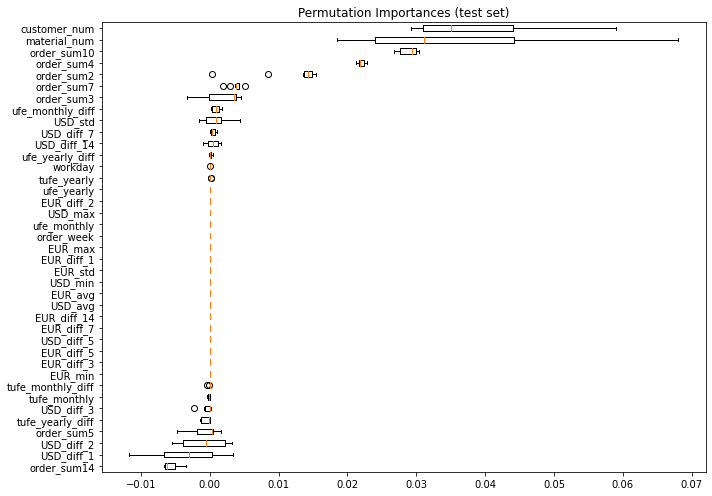

In [28]:
from sklearn.inspection import permutation_importance

result = permutation_importance(pipeline, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,7))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [29]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [30]:
from tensorflow.python.keras import backend as K
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
K.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5



In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

In [32]:
cut_point = int(X.shape[0]/5*4)
X_train = X.loc[:cut_point]
y_train = y.loc[:cut_point]
X_test = X.loc[cut_point:]
y_test = y.loc[cut_point:]

In [33]:
trans_pipe = create_pipeline_transofmer()
X_train = trans_pipe.fit_transform(X_train).toarray()
X_test = trans_pipe.transform(X_test).toarray()

In [34]:
def model_1():
    
    model = Sequential([
                        Dense(100, activation='relu'),
                        Dropout(0.2),
                        Dense(30, activation='relu'),
                        Dense(1)
                        ])

    model.compile(loss='mean_squared_error', optimizer=Adam(0.001))
    
    return model

model = model_1()
history = model.fit(X_train, y_train, epochs=2, batch_size=16, validation_data = (X_test, y_test), verbose=2)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
def model_2():
    
    model = Sequential([
                        LSTM(20, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1],1)),
                        # LSTM(30, return_sequences=True,activation='tanh'),
                        # Dropout(0.2),
                        # LSTM(20, return_sequences=True,activation='tanh'),
                        Dense(1)
                        ])

    model.compile(loss='mean_squared_error', optimizer=Adam())
    
    return model

In [36]:
from tensorflow.python.keras import backend as K
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
K.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5



In [38]:
X_train_3d = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
model = model_2()
history = model.fit(X_train_3d, y_train, 
                    epochs=1, batch_size=8, validation_data = (X_test, y_test), verbose=2)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print('train rmse:', np.sqrt(history.history['loss'][-1])) 
print('test rmse:', np.sqrt(history.history['loss'][-1]))

# 2021

In [39]:
dates21 = pd.DataFrame(pd.date_range(start='01-01-2021', end='30-11-2021'), columns=['date'])
weeks21 = pd.DataFrame(range(1,49), columns=['order_week'])

In [40]:
currency_21 = pd.read_csv('data/currency_21.csv', parse_dates=['date'])
currency_21.dropna(inplace=True)
currency_21['order_week'] = currency_21['date'].dt.week

for curr in ['EUR', 'USD']:
    for operator in ['min', 'max', 'avg', 'std']:
        currency_21[curr + '_' + operator] = currency_21[curr]
        
currency_21 = currency_21.groupby('order_week').agg({'EUR_min':'min', 'EUR_max':'max', 'EUR_avg':'mean', 'EUR_std':'std', 
                                               'USD_min':'min', 'USD_max':'max', 'USD_avg':'mean', 'USD_std':'std'}).reset_index()    

currency_21['USD_diff_1'] = currency_21['USD_avg'].diff(1)
currency_21['USD_diff_2'] = currency_21['USD_avg'].diff(2)
currency_21['USD_diff_3'] = currency_21['USD_avg'].diff(3)
currency_21['USD_diff_5'] = currency_21['USD_avg'].diff(5)
currency_21['USD_diff_7'] = currency_21['USD_avg'].diff(7)
currency_21['USD_diff_14'] = currency_21['USD_avg'].diff(14)

currency_21['EUR_diff_1'] = currency_21['EUR_avg'].diff(1)
currency_21['EUR_diff_2'] = currency_21['EUR_avg'].diff(2)
currency_21['EUR_diff_3'] = currency_21['EUR_avg'].diff(3)
currency_21['EUR_diff_5'] = currency_21['EUR_avg'].diff(5)
currency_21['EUR_diff_7'] = currency_21['EUR_avg'].diff(7)
currency_21['EUR_diff_14'] = currency_21['EUR_avg'].diff(14)
currency_21.fillna(method='bfill', inplace=True)

C:\Users\ISMAIL~1\AppData\Local\Temp/ipykernel_15292/238482258.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  currency_21['order_week'] = currency_21['date'].dt.week


In [41]:
holidays_21 = pd.read_excel('data/holidays_21.xlsx', parse_dates=['date'])
holidays_21 = pd.merge(dates21, holidays_21, on=['date'], how='left')
holidays_21.fillna(1.0, inplace=True)
holidays_21['order_week'] = holidays_21['date'].dt.week
holidays_21 = holidays_21.groupby('order_week')['workday'].sum().reset_index()

C:\Users\ISMAIL~1\AppData\Local\Temp/ipykernel_15292/4228216114.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  holidays_21['order_week'] = holidays_21['date'].dt.week


In [42]:
tufe_21 = pd.read_excel('data/tufe_21.xlsx', parse_dates=['date'])
tufe_21.sort_values(by='date', inplace=True)
tufe_21['yearly_diff'] = tufe_21['yearly'].diff()
tufe_21['monthly_diff'] = tufe_21['monthly'].diff()
tufe_21.loc[9, 'yearly_diff'] = 14.97-14.60
tufe_21.loc[9, 'monthly_diff'] = 1.68-1.25
tufe_21 = pd.merge(dates21, tufe_21, on=['date'], how='left')
tufe_21.fillna(method='ffill', inplace=True)
tufe_21.columns = ['tufe_'+i for i in tufe_21.columns]
tufe_21['order_week'] = tufe_21['tufe_date'].dt.week
tufe_21 = tufe_21.groupby('order_week').min().reset_index().drop(['tufe_date'], axis=1)

C:\Users\ISMAIL~1\AppData\Local\Temp/ipykernel_15292/2434128108.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  tufe_21['order_week'] = tufe_21['tufe_date'].dt.week


In [43]:
ufe_21 = pd.read_excel('data/ufe_21.xlsx', parse_dates=['date'])
ufe_21.sort_values(by='date', inplace=True)
ufe_21['yearly_diff'] = ufe_21['yearly'].diff()
ufe_21['monthly_diff'] = ufe_21['monthly'].diff()
ufe_21.loc[10, 'yearly_diff'] = 26.16-25.15
ufe_21.loc[10, 'monthly_diff'] = 2.66-2.36
ufe_21 = pd.merge(dates21, ufe_21, on=['date'], how='left')
ufe_21.fillna(method='ffill', inplace=True)
ufe_21.columns = ['ufe_'+i for i in ufe_21.columns]
ufe_21['order_week'] = ufe_21['ufe_date'].dt.week
ufe_21 = ufe_21.groupby('order_week').min().reset_index().drop(['ufe_date'], axis=1)

C:\Users\ISMAIL~1\AppData\Local\Temp/ipykernel_15292/3773209644.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  ufe_21['order_week'] = ufe_21['ufe_date'].dt.week


In [102]:
all_mats = pd.DataFrame(order_df['material_num'].unique(), columns=['material_num'])
all_mats['key'] = 1
all_custs = pd.DataFrame(order_df['customer_num'].unique(), columns=['customer_num'])
all_custs['key'] = 1
weeks21['key'] = 1

order_21 = pd.merge(weeks21, all_custs, on=['key'])
order_21 = pd.merge(order_21, all_mats, on=['key']).drop('key', axis=1)

In [108]:
order_21 = pd.merge(order_21, currency_21, on=['order_week'], how='left')
order_21 = pd.merge(order_21, tufe_21, on=['order_week'], how='left')
order_21 = pd.merge(order_21, ufe_21, on=['order_week'], how='left')
order_21 = pd.merge(order_21, holidays_21, on=['order_week'], how='left')

MemoryError: Unable to allocate 4.14 GiB for an array with shape (20, 27786240) and data type float64

In [ ]:
order_21.head()

In [ ]:
last_week_for_prediction = 53-14
past_data_for_21 = order_df[order_df['order_week']>last_week_for_prediction]

In [106]:
del order_df, model_df
import gc
gc.collect()

319

In [107]:
import gc
gc.collect()

21

In [ ]:
order_21['week'] = order_21['week']+53

In [ ]:
tmp_data = pd.concat([past_data_for_21, order_21])

In [ ]:
for i in range(1,15):
    tmp_data['shift'+str(i)] = tmp_data.groupby(['material_num', 'customer_num'])['order_amount'].shift(i)

In [ ]:
sum_cols = {}

for num_week in [2, 3, 4, 5, 7, 10, 14]:
    
    week_cols = []
    
    for i in range(1,1+num_week):
        
        week_cols.append('shift'+str(i))
    sum_cols['sum'+str(num_week)] = week_cols  

In [104]:
for col_name, cols_to_sum in sum_cols.items():
    
    order_df['order_'+col_name] = order_df[cols_to_sum].sum(axis=1)

NameError: name 'sum_cols' is not defined

In [ ]:
cols_to_drop = ['shift1', 'shift2', 'shift3', 'shift4', 'shift5', 'shift6', 'shift7', 
                'shift8', 'shift9', 'shift10', 'shift11', 'shift12', 'shift13', 'shift14']

In [ ]:
tmp_data.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
order_21 = tmp_data[tmp_data['order_week']>53]

In [ ]:
preds = pd.DataFrame(index=order_21.index, columns=['pred'])

In [ ]:
for week in order_21.order_week.unique():
    pipeline.predict(order_21[order_21['order_week']==week])

In [53]:
past_data_for_21

,order_week,material_num,customer_num,order_amount,order_sum2,order_sum3,order_sum4,order_sum5,order_sum7,order_sum10,...,EUR_diff_14,tufe_yearly,tufe_monthly,tufe_yearly_diff,tufe_monthly_diff,ufe_yearly,ufe_monthly,ufe_yearly_diff,ufe_monthly_diff,workday
21086910,40,91704,M10125,5,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.329729,11.75,0.97,-0.02,0.11,14.33,2.65,2.80,0.30,7.0
21086911,40,91704,M10140,8,0.0,0.000000,0.0,0.0,0.571429,0.7,...,1.329729,11.75,0.97,-0.02,0.11,14.33,2.65,2.80,0.30,7.0
21086912,40,91704,M10142,0,4.0,2.666667,2.0,1.6,2.285714,2.2,...,1.329729,11.75,0.97,-0.02,0.11,14.33,2.65,2.80,0.30,7.0
21086913,40,91704,M10143,0,3.0,2.000000,1.5,1.2,0.857143,0.6,...,1.329729,11.75,0.97,-0.02,0.11,14.33,2.65,2.80,0.30,7.0
21086914,40,91704,M10158,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.329729,11.75,0.97,-0.02,0.11,14.33,2.65,2.80,0.30,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28656565,53,61011625,M10012,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.166018,14.60,1.25,0.57,-1.05,25.15,2.36,2.04,-1.72,4.0
28656566,53,61011625,C-10284,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.166018,14.60,1.25,0.57,-1.05,25.15,2.36,2.04,-1.72,4.0
28656567,53,61011625,C-10282,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.166018,14.60,1.25,0.57,-1.05,25.15,2.36,2.04,-1.72,4.0
28656568,53,61011625,M10319,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.166018,14.60,1.25,0.57,-1.05,25.15,2.36,2.04,-1.72,4.0


In [57]:
order_21.columns

Index(['order_week', 'material_num', 'customer_num', 'order_amount',
       'order_sum2', 'order_sum3', 'order_sum4', 'order_sum5', 'order_sum7',
       'order_sum10', 'order_sum14', 'cust_sum2', 'cust_sum3', 'cust_sum4',
       'cust_sum5', 'cust_sum7', 'cust_sum10', 'cust_sum14', 'prod_sum2',
       'prod_sum3', 'prod_sum4', 'prod_sum5', 'prod_sum7', 'prod_sum10',
       'prod_sum14', 'whole_sum2', 'whole_sum3', 'whole_sum4', 'whole_sum5',
       'whole_sum7', 'whole_sum10', 'whole_sum14', 'EUR_min', 'EUR_max',
       'EUR_avg', 'EUR_std', 'USD_min', 'USD_max', 'USD_avg', 'USD_std',
       'USD_diff_1', 'USD_diff_2', 'USD_diff_3', 'USD_diff_5', 'USD_diff_7',
       'USD_diff_14', 'EUR_diff_1', 'EUR_diff_2', 'EUR_diff_3', 'EUR_diff_5',
       'EUR_diff_7', 'EUR_diff_14', 'tufe_yearly', 'tufe_monthly',
       'tufe_yearly_diff', 'tufe_monthly_diff', 'ufe_yearly', 'ufe_monthly',
       'ufe_yearly_diff', 'ufe_monthly_diff', 'workday_x', 'workday_y'],
      dtype='object')

In [ ]:
order_21

In [55]:
order_21['order_week']

0            1
1            1
2            1
3            1
4            1
            ..
28656565    53
28656566    53
28656567    53
28656568    53
28656569    53
Name: order_week, Length: 28656570, dtype: int64

In [ ]:
past_20_data = pd.DataFrame()

for i in [2, 3, 4, 5, 7, 10, 14]:
    past_20_data['order_sum'+str(i)] = 
    order_21[]

In [ ]:
[2, 3, 4, 5, 7, 10, 14]

In [ ]:
pipeline